In [1]:
import pandas as pd
from collections import Counter
import numpy as np
from matplotlib import pyplot as plt


In [22]:
app_train = pd.read_csv('HW_2_logistic_regression/application_train.csv')
app_test = pd.read_csv('HW_2_logistic_regression/application_test.csv')

In [23]:
# функция для просмотра топ фичей по пропущенным значениям
def show_top_n_columns_by_missing_values(data, n):
  data = (data.isnull().sum() / len(data)) * 100
  data = data.drop(data[data == 0].index).sort_values(ascending=False)[:30]
  missing_data = pd.DataFrame({'Missing Ratio' :data})
  print(missing_data.head(n))


ntrain = app_train.shape[0]
ntest = app_test.shape[0]
# сохраним target в отдельную переменную
y_train = app_train['TARGET']
app_train.drop(['TARGET'], axis=1, inplace=True)
# объединим датасеты для дальнейших преобразований
united_app = pd.concat((app_test, app_train)).reset_index(drop=True)

In [9]:
show_top_n_columns_by_missing_values(united_app, 15)

                          Missing Ratio
COMMONAREA_MEDI               69.714109
COMMONAREA_AVG                69.714109
COMMONAREA_MODE               69.714109
NONLIVINGAPARTMENTS_AVG       69.293343
NONLIVINGAPARTMENTS_MODE      69.293343
NONLIVINGAPARTMENTS_MEDI      69.293343
FONDKAPREMONT_MODE            68.235393
LIVINGAPARTMENTS_AVG          68.203674
LIVINGAPARTMENTS_MEDI         68.203674
LIVINGAPARTMENTS_MODE         68.203674
FLOORSMIN_AVG                 67.678489
FLOORSMIN_MODE                67.678489
FLOORSMIN_MEDI                67.678489
YEARS_BUILD_AVG               66.330578
YEARS_BUILD_MEDI              66.330578


In [10]:
print(united_app['COMMONAREA_MEDI'].corr(united_app['COMMONAREA_AVG']), united_app['COMMONAREA_MEDI'].corr(united_app['COMMONAREA_MODE']))
print(united_app['NONLIVINGAPARTMENTS_AVG'].corr(united_app['NONLIVINGAPARTMENTS_MODE']), united_app['NONLIVINGAPARTMENTS_AVG'].corr(united_app['NONLIVINGAPARTMENTS_MEDI']))
print(united_app['LIVINGAPARTMENTS_AVG'].corr(united_app['LIVINGAPARTMENTS_MEDI']), united_app['LIVINGAPARTMENTS_AVG'].corr(united_app['LIVINGAPARTMENTS_MODE']))
print(united_app['FLOORSMIN_AVG'].corr(united_app['FLOORSMIN_MODE']), united_app['FLOORSMIN_AVG'].corr(united_app['FLOORSMIN_MEDI']))
print(united_app['YEARS_BUILD_AVG'].corr(united_app['YEARS_BUILD_MEDI']), united_app['YEARS_BUILD_AVG'].corr(united_app['YEARS_BUILD_MODE']))
print(united_app['LANDAREA_AVG'].corr(united_app['LANDAREA_MEDI']), united_app['LANDAREA_AVG'].corr(united_app['LANDAREA_MODE']))
print(united_app['BASEMENTAREA_MODE'].corr(united_app['BASEMENTAREA_AVG']), united_app['BASEMENTAREA_MODE'].corr(united_app['BASEMENTAREA_MEDI']))
print(united_app['NONLIVINGAREA_AVG'].corr(united_app['NONLIVINGAREA_MODE']), united_app['NONLIVINGAREA_AVG'].corr(united_app['NONLIVINGAREA_MEDI']))
print(united_app['ELEVATORS_MODE'].corr(united_app['ELEVATORS_MEDI']), united_app['ELEVATORS_MODE'].corr(united_app['ELEVATORS_AVG']))

0.9959329235120458 0.980136930665965
0.9683450071217975 0.9896612412984713
0.9943145612248373 0.9704704417360147
0.985816791206454 0.997197184331415
0.9985402212980031 0.989593303868515
0.9916085351291151 0.9745284740539331
0.9721298168563488 0.9768628143708254
0.9677614124304057 0.9912276320806473
0.9833317033353872 0.9792245723691423


Как видим, подобные признаки сильно коррелируют, поэтому заменим 3 на 1, являющийся просто средним среди 3

In [11]:
def change_correlated_features_on_avg(feature_names):
  for name in feature_names:
    try:
      united_app[name+'_AVG'] = (united_app[name+'_AVG'] + united_app[name+'_MODE'] + united_app[name+'_MEDI'])/3
      united_app.drop([name+'_MODE', name+'_MEDI'], axis=1, inplace=True)
    except:
      pass
feature_names_to_be_replaced_on_avg = ['COMMONAREA', 'NONLIVINGAPARTMENTS', 'LIVINGAPARTMENTS',
                                       'FLOORSMIN', 'YEARS_BUILD', 'LANDAREA', 'BASEMENTAREA',
                                       'NONLIVINGAREA', 'ELEVATORS', 'APARTMENTS', 
                                       'ENTRANCES', 'LIVINGAREA', 'FLOORSMAX', 
                                       'YEARS_BEGINEXPLUATATION']

change_correlated_features_on_avg(feature_names=feature_names_to_be_replaced_on_avg)

In [13]:
# заполним nan у категориальных признаков рандомно согласно исходному распределению
def fill_cat_features_with_random_value(data, column_names):
  for column_name in column_names:
    dict_without_nan = dict(Counter(data[~ pd.isna(data[column_name])][column_name]))
    values = list(dict_without_nan.keys())
    probabilities = [value/sum(dict_without_nan.values()) for value in dict_without_nan.values()]
    data.loc[pd.isna(data[column_name]), [column_name]] = data[pd.isna(data[column_name])].apply(lambda row: np.random.choice(values, p=probabilities), axis=1)

fill_cat_features_with_random_value(united_app, ['NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'EMERGENCYSTATE_MODE',
                                                 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE'])

In [14]:
# уберем некоторые признаки -- у некоторых все заполнено одним значением, у других одинаковые распределение между классов
united_app.drop(['COMMONAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_AVG',
                 'FLOORSMIN_AVG', 'YEARS_BUILD_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 
                 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_REQ_CREDIT_BUREAU_HOUR',
                 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
                 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 
                 'DEF_60_CNT_SOCIAL_CIRCLE'], axis=1, inplace=True)

In [15]:
# заменим числовые пропуски
united_app['EXT_SOURCE_1'] = united_app['EXT_SOURCE_1'].fillna(united_app['EXT_SOURCE_1'].mean())
united_app['EXT_SOURCE_3'] = united_app['EXT_SOURCE_3'].fillna(united_app['EXT_SOURCE_3'].mean())
united_app['EXT_SOURCE_2'] = united_app['EXT_SOURCE_2'].fillna(united_app['EXT_SOURCE_2'].median())
united_app['AMT_GOODS_PRICE'] = united_app['AMT_GOODS_PRICE'].fillna(united_app['AMT_GOODS_PRICE'].median())
united_app['AMT_ANNUITY'] = united_app['AMT_ANNUITY'].fillna(united_app['AMT_ANNUITY'].median())
united_app['CNT_FAM_MEMBERS'] = united_app['CNT_FAM_MEMBERS'].fillna(united_app['CNT_FAM_MEMBERS'].mean())
united_app['DAYS_LAST_PHONE_CHANGE'] = united_app['DAYS_LAST_PHONE_CHANGE'].fillna(united_app['DAYS_LAST_PHONE_CHANGE'].mean())

Сделаем из признака 'own_car_age' новый -- см. код ниже



In [24]:
cars_age = united_app['OWN_CAR_AGE']
for i in range(len(cars_age)):
  if np.isnan(cars_age[i]):
    pass
  else:
    if cars_age[i] == 0:
      cars_age[i] = 'no_car'
    elif 0 < cars_age[i] <= 3:
      cars_age[i] = 'new_car'
    elif 3 < cars_age[i] <= 5:
      cars_age[i] = 'almost_new'
    elif 5 < cars_age[i] <= 10:
      cars_age[i] = 'casual'
    elif 10 < cars_age[i] <= 15:
      cars_age[i] = 'almost_old'
    else:
      cars_age[i] = 'old'
      

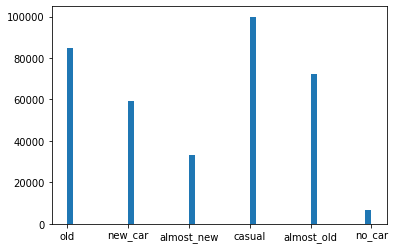

In [25]:
fill_cat_features_with_random_value(united_app, ['OWN_CAR_AGE'])
plt.hist(united_app['OWN_CAR_AGE'], bins=50);

Аналогично сделаем дргуие новые признаки


In [ ]:
land = united_app['LANDAREA_AVG']
for i in range(len(land)):
  if np.isnan(land[i]):
    pass
  else:
    if land[i] < 0.02:
      land[i] = 'no_land'
    elif 0.02 <= land[i] < 0.1:
      land[i] = 'has_land'
    elif land[i] >= 0.1:
      land[i] = 'has_alotof_land'

base_area = united_app['BASEMENTAREA_AVG']
for i in range(len(base_area)):
  if np.isnan(base_area[i]):
    pass
  else:
    if base_area[i] < 0.02:
      base_area[i] = 'no_basearea'
    elif 0.02 <= base_area[i] < 0.1:
      base_area[i] = 'has_basearea'
    elif base_area[i] >= 0.1:
      base_area[i] = 'has_alotof_basearea'

nonliv_area = united_app['NONLIVINGAREA_AVG']
for i in range(len(nonliv_area)):
  if np.isnan(nonliv_area[i]):
    pass
  else:
    if nonliv_area[i] < 0.02:
      nonliv_area[i] = 'no_nonliv'
    elif nonliv_area[i] >= 0.02:
      nonliv_area[i] = 'yes_nonliv'

elevators = united_app['ELEVATORS_AVG']
for i in range(len(elevators)):
  if np.isnan(elevators[i]):
    pass
  else:
    if elevators[i] < 0.02:
      elevators[i] = 'no_elevators'
    elif 0.02 <= elevators[i] < 0.1:
      elevators[i] = 'few_elevators'
    elif elevators[i] >= 0.1:
      elevators[i] = 'has_alotof_elevators'

apartaments = united_app['APARTMENTS_AVG']
for i in range(len(apartaments)):
  if np.isnan(apartaments[i]):
    pass
  else:
    if apartaments[i] < 0.02:
      apartaments[i] = 'no_apartaments'
    elif 0.02 <= apartaments[i] < 0.06:
      apartaments[i] = 'few_apartaments'
    elif 0.06 <= apartaments[i] < 0.15:
      apartaments[i] = 'alot_apartaments'
    elif apartaments[i] >= 0.15:
      apartaments[i] = 'much_apartaments'

entrances = united_app['ENTRANCES_AVG']
for i in range(len(entrances)):
  if np.isnan(entrances[i]):
    pass
  else:
    if entrances[i] < 0.1:
      entrances[i] = 'few_entrances'
    elif entrances[i] >= 0.1:
      entrances[i] = 'much_entrances'

living_area = united_app['LIVINGAREA_AVG']
for i in range(len(living_area)):
  if np.isnan(living_area[i]):
    pass
  else:
    if living_area[i] < 0.02:
      living_area[i] = 'no_living'
    elif 0.02 <= living_area[i] < 0.06:
      living_area[i] = 'few_living'
    elif 0.06 <= living_area[i] < 0.15:
      living_area[i] = 'alot_living'
    elif living_area[i] >= 0.15:
      living_area[i] = 'much_living'

floors = united_app['FLOORSMAX_AVG']
for i in range(len(floors)):
  if np.isnan(floors[i]):
    pass
  else:
    if floors[i] < 0.2:
      floors[i] = 'few_floors'
    elif 0.2 <= floors[i] < 0.35:
      floors[i] = 'avg_floors'
    else:
      floors[i] = 'much_floors'

total_area = united_app['TOTALAREA_MODE']
for i in range(len(total_area)):
  if np.isnan(total_area[i]):
    pass
  else:
    if total_area[i] < 0.02:
      total_area[i] = 'no_area'
    elif 0.02 <= total_area[i] < 0.1:
      total_area[i] = 'few_area'
    elif 0.1 <= total_area[i] < 0.2:
      total_area[i] = 'more_area'
    elif 0.2 <= total_area[i] < 0.3:
      total_area[i] = 'much_area'
    else:
      total_area[i] = 'huge_area'

fill_cat_features_with_random_value(united_app, ['LANDAREA_AVG', 'BASEMENTAREA_AVG', 'NONLIVINGAREA_AVG', 'ELEVATORS_AVG', 'APARTMENTS_AVG',
                                                 'ENTRANCES_AVG', 'LIVINGAREA_AVG', 'FLOORSMAX_AVG', 'TOTALAREA_MODE'])

In [ ]:
united_app_no_nans = pd.read_csv('united_app_without_nans.csv')

In [ ]:
# удалим выбросы, некоторые фичи
united_app_no_nans.loc[united_app_no_nans['DAYS_EMPLOYED'] > 350000, ['DAYS_EMPLOYED']] = united_app_no_nans['DAYS_EMPLOYED'].median()
united_app_no_nans.drop(['REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 
                         'REG_CITY_NOT_LIVE_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_4','FLAG_DOCUMENT_7', 
                         'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 
                         'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_19',
                         'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21'], axis=1, inplace=True)

In [ ]:
united_app_no_nans.drop(['FLAG_MOBIL', 'FLAG_CONT_MOBILE'], axis=1, inplace=True)

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

In [ ]:
cat_features = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 
                'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE','OWN_CAR_AGE',  'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE',
                'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'LANDAREA_AVG', 'LIVINGAREA_AVG', 
                'NONLIVINGAREA_AVG', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'TOTALAREA_MODE', 'EMERGENCYSTATE_MODE']

features_minmax_scaled = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 
                         'DAYS_ID_PUBLISH', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'CNT_FAM_MEMBERS', 
                         'DAYS_LAST_PHONE_CHANGE', 'EXT_SOURCE_2']

features_standard_scaled = ['DAYS_BIRTH', 'HOUR_APPR_PROCESS_START']

In [ ]:
# закодируем категориальные признаки
# отмасштабируем числовые
for c in cat_features:
    lbl = LabelEncoder() 
    lbl.fit(list(united_app_no_nans[c].values)) 
    united_app_no_nans[c] = lbl.transform(list(united_app_no_nans[c].values))
    
for c in features_minmax_scaled:
    scaler = MinMaxScaler()
    scaler.fit(united_app_no_nans[c].values.reshape(-1, 1)) 
    united_app_no_nans[c] = scaler.transform(united_app_no_nans[c].values.reshape(-1, 1))

for c in features_standard_scaled:
    scaler = StandardScaler()
    scaler.fit(united_app_no_nans[c].values.reshape(-1, 1)) 
    united_app_no_nans[c] = scaler.transform(united_app_no_nans[c].values.reshape(-1, 1))

In [ ]:
united_app_no_nans.to_csv('united_norm_encoded.csv', index=False)